In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.graph_objects as go

# K-mean Venue-data within 1km

In [90]:
# Import venue data within 1km of each neighborhood
venue_data = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/data/all_venues_data_1km.csv')
venue_data.head()

,id,accounting,aquarium,art_gallery,bakery,bank,bar,beauty_salon,bicycle_store,book_store,...,store,subway_station,supermarket,synagogue,tourist_attraction,transit_station,travel_agency,university,veterinary_care,zoo
0,nyu_2451_34572.1,1,0,0,1,2,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,nyu_2451_34572.10,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,nyu_2451_34572.100,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,nyu_2451_34572.101,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,nyu_2451_34572.102,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [91]:
# Create function to find the most common venues per neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [92]:
# Create new dataframe for most common venues
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['id'] = venue_data['id']

for ind in np.arange(venue_data.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(venue_data.iloc[ind, :], num_top_venues)

In [93]:
venues_sorted.head()

,id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,nyu_2451_34572.1,school,secondary_school,bank,plumber,drugstore
1,nyu_2451_34572.10,secondary_school,funeral_home,church,lodging,school
2,nyu_2451_34572.100,doctor,dentist,car_dealer,restaurant,drugstore
3,nyu_2451_34572.101,lodging,cafe,museum,plumber,place_of_worship
4,nyu_2451_34572.102,restaurant,park,church,real_estate_agency,travel_agency


In [94]:
# Import neighborhood data
neighborhood_data = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/old_dataset.csv')
neighborhood_data = neighborhood_data.iloc[:, 1:6]
neighborhood_data.head()

,id,borough,neighborhood,longitude,latitude
0,nyu_2451_34572.1,Bronx,Wakefield,-73.847201,40.894705
1,nyu_2451_34572.2,Bronx,Co-op City,-73.829939,40.874294
2,nyu_2451_34572.3,Bronx,Eastchester,-73.827806,40.887556
3,nyu_2451_34572.4,Bronx,Fieldston,-73.905643,40.895437
4,nyu_2451_34572.5,Bronx,Riverdale,-73.912585,40.890834


In [95]:
# Drop neighborhood ID to create numerical data for k-means clustering
venue_clustering = venue_data.drop('id', axis=1)

In [96]:
# Create elbow graph function
def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show() 

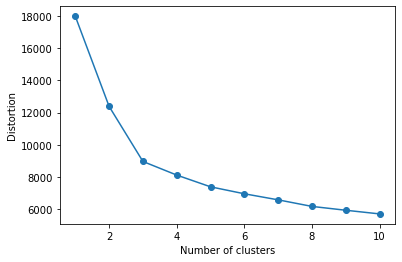

In [97]:
# Plot elbow graph
plot_distortion(venue_clustering)

In [98]:
# Cluster data points using kmeans and get labels
kclusters = 3

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_clustering)

kmeans.labels_[0:10] 

array([0, 0, 1, 2, 0, 0, 0, 0, 0, 0], dtype=int32)

In [103]:
# Add cluster labels to venue data
venues_sorted.insert(0, 'clusters', kmeans.labels_)
clusters = venues_sorted.clusters.tolist()
venues_sorted = venues_sorted.drop('clusters', axis=1)

# Merge venue data with neighborhood data
all_venue_data = neighborhood_data.copy()
all_venue_data = pd.merge(all_venue_data, venues_sorted, on='id')
all_venue_data['clusters'] = clusters
all_venue_data = all_venue_data.drop('id', axis=1)

all_venue_data.head()

,borough,neighborhood,longitude,latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,clusters
0,Bronx,Wakefield,-73.847201,40.894705,school,secondary_school,bank,plumber,drugstore,0
1,Bronx,Co-op City,-73.829939,40.874294,health,secondary_school,department_store,dentist,school,0
2,Bronx,Eastchester,-73.827806,40.887556,health,car_repair,primary_school,restaurant,storage,1
3,Bronx,Fieldston,-73.905643,40.895437,school,synagogue,restaurant,dentist,church,2
4,Bronx,Riverdale,-73.912585,40.890834,health,cafe,school,veterinary_care,university,0


### Mapping

In [ ]:
import folium
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors

In [ ]:
# Create a map of new york

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [ ]:
# Plot clusters on map of New York
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_venue_data['latitude'], all_venue_data['longitude'], all_venue_data['neighborhood'],all_venue_data['clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [131]:
cluster0 = all_venue_data.loc[all_venue_data['clusters'] == 0, all_venue_data.columns[[1] + list(range(4, all_venue_data.shape[1]))]]
cluster1 = all_venue_data.loc[all_venue_data['clusters'] == 1, all_venue_data.columns[[1] + list(range(4, all_venue_data.shape[1]))]]
cluster2 = all_venue_data.loc[all_venue_data['clusters'] == 2, all_venue_data.columns[[1] + list(range(4, all_venue_data.shape[1]))]]

In [132]:
print('--cluster0--')
print()
print('Top 5 most common venue type')
print(cluster0['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster0['2nd Most Common Venue'].value_counts()[:5])
print()
print('Top 5 third most common venue type')
print(cluster0['3rd Most Common Venue'].value_counts()[:5])

--cluster0--

Top 5 most common venue type
doctor        72
lodging       42
restaurant    22
school        15
health        15
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
restaurant    21
health        19
doctor        18
bar           16
lodging       15
Name: 2nd Most Common Venue, dtype: int64

Top 5 third most common venue type
restaurant          16
school              13
secondary_school    13
doctor              12
lodging             11
Name: 3rd Most Common Venue, dtype: int64


In [133]:
print('--cluster1--')
print()
print('Top 5 most common venue type')
print(cluster1['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster1['2nd Most Common Venue'].value_counts()[:5])
print()
print('Top 5 third most common venue type')
print(cluster1['3rd Most Common Venue'].value_counts()[:5])

--cluster1--

Top 5 most common venue type
doctor       17
lodging       6
school        3
church        2
drugstore     2
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
school        4
doctor        3
restaurant    3
health        3
lodging       2
Name: 2nd Most Common Venue, dtype: int64

Top 5 third most common venue type
health            5
restaurant        3
primary_school    2
bar               2
lodging           2
Name: 3rd Most Common Venue, dtype: int64


In [ ]:
print('--cluster2--')
print()
print('Top 5 most common venue type')
print(cluster2['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster2['2nd Most Common Venue'].value_counts()[:5])
print()
print('Top 5 third most common venue type')
print(cluster2['3rd Most Common Venue'].value_counts()[:5])

--cluster2--

Top 5 most common venue type
doctor                     9
school                     2
general_contractor         2
local_government_office    1
health                     1
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
school       4
lodging      3
hospital     2
health       2
synagogue    1
Name: 2nd Most Common Venue, dtype: int64

Top 5 third most common venue type
restaurant          3
school              2
store               2
department_store    1
hardware_store      1
Name: 3rd Most Common Venue, dtype: int64


In [ ]:
def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
y_km = kmeans.fit_predict(venue_clustering)

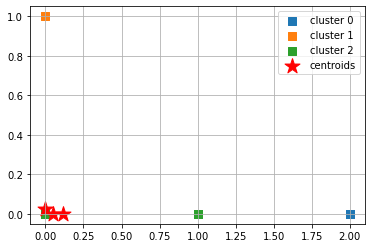

In [ ]:
plot_clusters(np.array(venue_clustering), y_km, plt_cluster_centers= True)

# Resturant Data

In [ ]:
# Import venue data within 1km of each neighborhood
restaurant_data = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/data/yelp_restaurant_type_counts_1km.csv')
restaurant_data.columns.values[0] = "id"
restaurant_data.head()

,id,caribbean,cocktailbars,seafood,spanish,chinese,breakfast_brunch,japanese,thai,wraps,...,pharmacy,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,nyu_2451_34572.1,17.0,1.0,3.0,1.0,4.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,nyu_2451_34572.2,5.0,0.0,4.0,0.0,4.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,nyu_2451_34572.3,7.0,0.0,5.0,0.0,1.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,nyu_2451_34572.4,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,nyu_2451_34572.5,0.0,2.0,2.0,0.0,3.0,1.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Create new dataframe for most common venues
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
restaurant_sorted = pd.DataFrame(columns=columns)
restaurant_sorted['id'] = restaurant_data['id']

for ind in np.arange(restaurant_data.shape[0]):
    restaurant_sorted.iloc[ind, 1:] = return_most_common_venues(restaurant_data.iloc[ind, :], num_top_venues)

restaurant_sorted.head()

,id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,nyu_2451_34572.1,caribbean,pizza,sandwiches,burgers,chinese
1,nyu_2451_34572.2,hotdogs,pizza,caribbean,seafood,chicken_wings
2,nyu_2451_34572.3,caribbean,hotdogs,burgers,seafood,pizza
3,nyu_2451_34572.4,bars,delis,tradamerican,mexican,pizza
4,nyu_2451_34572.5,sandwiches,delis,pizza,burgers,bars


In [105]:
# Numeric Data for clustering
restaurant_clustering = restaurant_data.drop('id', axis=1)

### K-Means

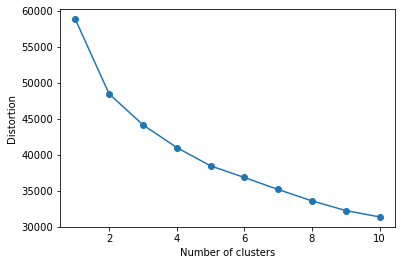

In [107]:
# Plot elbow graph
plot_distortion(restaurant_clustering)

In [118]:
# Cluster data points using kmeans and get labels
kclusters_resturant = 2

kmeans_restaurant = KMeans(n_clusters=kclusters_resturant, random_state=0).fit(restaurant_clustering)

kmeans_restaurant.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [119]:
y_km_restaurants = kmeans_restaurant.fit_predict(restaurant_clustering)

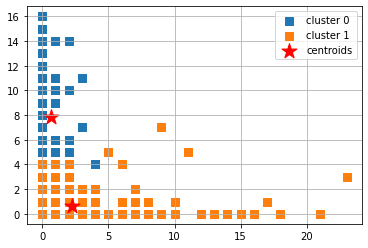

In [120]:
plot_clusters(np.array(restaurant_clustering), y_km_restaurants, plt_cluster_centers= True)

In [123]:
# Add cluster labels to venue data
restaurant_sorted.insert(0, 'clusters', kmeans.labels_)
clusters_resturant = restaurant_sorted.clusters.tolist()
restaurant_sorted = restaurant_sorted.drop('clusters', axis=1)

# Merge venue data with neighborhood data
all_restaurant_data = neighborhood_data.copy()
all_restaurant_data = pd.merge(all_restaurant_data, restaurant_sorted, on='id')
all_restaurant_data['clusters'] = clusters
all_restaurant_data = all_restaurant_data.drop('id', axis=1)

all_restaurant_data.head()

,borough,neighborhood,longitude,latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,clusters
0,Bronx,Wakefield,-73.847201,40.894705,caribbean,pizza,sandwiches,burgers,chinese,0
1,Bronx,Co-op City,-73.829939,40.874294,hotdogs,pizza,caribbean,seafood,chicken_wings,0
2,Bronx,Eastchester,-73.827806,40.887556,caribbean,hotdogs,burgers,seafood,pizza,1
3,Bronx,Fieldston,-73.905643,40.895437,bars,delis,tradamerican,mexican,pizza,2
4,Bronx,Riverdale,-73.912585,40.890834,sandwiches,delis,pizza,burgers,bars,0


### Mapping

In [127]:
# Plot clusters on map of New York
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters_resturant)
ys = [i + x + (i*x)**2 for i in range(kclusters_resturant)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_restaurant_data['latitude'], all_restaurant_data['longitude'], all_restaurant_data['neighborhood'],all_restaurant_data['clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [137]:
cluster0_restaurant = all_restaurant_data.loc[all_restaurant_data['clusters'] == 0, all_restaurant_data.columns[[0] + [1] + list(range(4, all_restaurant_data.shape[1]))]]
cluster1_restaurant = all_restaurant_data.loc[all_restaurant_data['clusters'] == 1, all_restaurant_data.columns[[0] + [1] + list(range(4, all_restaurant_data.shape[1]))]]

In [139]:
cluster0_restaurant

,borough,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,clusters
0,Bronx,Wakefield,caribbean,pizza,sandwiches,burgers,chinese,0
1,Bronx,Co-op City,hotdogs,pizza,caribbean,seafood,chicken_wings,0
4,Bronx,Riverdale,sandwiches,delis,pizza,burgers,bars,0
5,Bronx,Kingsbridge,mexican,latin,burgers,sushi,pizza,0
6,Manhattan,Marble Hill,mexican,latin,dominican,burgers,spanish,0
...,...,...,...,...,...,...,...,...
299,Bronx,Kingsbridge Heights,mexican,latin,chinese,tradamerican,spanish,0
300,Brooklyn,Erasmus,caribbean,seafood,cafes,bakeries,cocktailbars,0
302,Queens,Hammels,pizza,chinese,mediterranean,sandwiches,caribbean,0
303,Queens,Bayswater,pizza,coffee,hotdogs,burgers,diners,0


In [145]:
print('--cluster0--')
print()
print('Top 5 most common venue type')
print(cluster0_restaurant['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster0_restaurant['2nd Most Common Venue'].value_counts()[:5])
print()
print('Most common borough')
print(cluster0_restaurant['borough'].value_counts()[:3])

--cluster0--

Top 5 most common venue type
italian      35
pizza        34
chinese      23
mexican      19
caribbean    18
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
pizza               40
italian             21
breakfast_brunch    21
chinese             19
cocktailbars        18
Name: 2nd Most Common Venue, dtype: int64

Most common borough
Queens           66
Brooklyn         60
Staten Island    49
Name: borough, dtype: int64


In [147]:
print('--cluster0--')
print()
print('Top 5 most common venue type')
print(cluster1_restaurant['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster1_restaurant['2nd Most Common Venue'].value_counts()[:5])
print()
print('Most common borough')
print(cluster1_restaurant['borough'].value_counts()[:3])

--cluster0--

Top 5 most common venue type
italian         8
pizza           6
caribbean       5
chinese         3
cocktailbars    3
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
delis      6
chinese    5
pizza      5
hotdogs    3
seafood    3
Name: 2nd Most Common Venue, dtype: int64

Most common borough
Staten Island    12
Queens           10
Brooklyn          9
Name: borough, dtype: int64
